<a href="https://colab.research.google.com/github/josefernandezest98/training/blob/main/Fruit_Thresholding/fruit_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit Thresholding for Image Segmentation: transforming tangerines into lemons

The demand for intelligent agriculture is increasing due to the continuous impact of world
food and environmental crises. In particular, fruit detection and segmentation is the main challenge to deal with nowadays. The article referenced in [[1]](#ref1) summarizes the computer vision's difficulties in fruit environments. It is highly recommendable to take a look at the reference before running this notebook, although they both are independent and there is no real need for a perfect understanding of this cells.



**Generating Synthetic Data**

One difficulty in the precision agriculture field is the variability of conditions depending on the environment. Achieving generalist neural networks under any circumstances requires huge datasets under different conditions, but it is not always feasible to have access to this. Let's imagine a particular problem: we have a detection and segmentation model of green grapes, which we want to infer on black grapes. However, there are no datasets available for black grapes. In this case, due to the characteristic structure of the bunch, we can treat the images, perhaps transforming them to grayscale, and the model would be able to generalize.

Nevertheless, we do not always have the characteristic bunch of grapes structure. On the contrary, the fruit generally has a compact structure that is easily confused in the environment of a tree. After testing with different models, we observed that grayscale training did not provide sufficient precision or recall to put the models into production, therefore this way is completely discarded.

Let's imagine another more complex example: we have a tangerine detection model, in this particular case a FASTER-RCNN that takes special advantage of the color characteristic to overfit the dataset. We want to retrain the model for the case of lemons, with a very similar structure but yellow color, and without any previous dataset or resources to allocate to marking. The proposed solution consists of using the FASTER-RCNN bounding boxes, identifying the fruit mask, and changing the color in the HSV space.

**HSV space**

HSL (for hue, saturation, lightness) and HSV (for hue, saturation, value; also known as HSB, for hue, saturation, brightness) are alternative representations of the RGB color model, designed in the 1970s by computer graphics researchers. In these models, colors of each hue are arranged in a radial slice, around a central axis of neutral colors which ranges from black at the bottom to white at the top.

* Hue: in HSV, hue represents color. In this model, hue is an angle from 0 degrees to 360 degrees.

* Saturation: saturation indicates the range of grey in the color space. It ranges from 0 to 100%. Sometimes the value is calculated from 0 to 1. When the value is ‘0,’ the color is grey and when the value is ‘1,’ the color is a primary color. A faded color is due to a lower saturation level, which means the color contains more grey.

* Value: value is the brightness of the color and varies with color saturation. It ranges from 0 to 100%. When the value is ‘0’ the color space will be totally black. With the increase in the value, the color space brightness up and shows various colors.

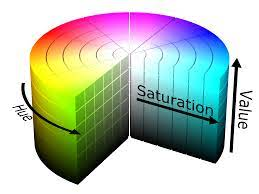

## Transforming tangerines into lemons

Let´s solve the proposed problem. Imagine that we have a dataset trained with tangerines, which we want to transform into lemons. The output of the FASTER-RCNN detects the fruit with considerable precision and recall, and the output is a text file with the bounding boxes in kitti format. Let´s take a look to our data.

In [13]:
# Libraries
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# function: plots an image with MatPlotLib
def show_img(image):
    if len(image.shape)==3:
        img2 = image[:,:,::-1]
        plt.imshow(img2)
        plt.show()
    else:
        img2 = image
        plt.imshow(img2,cmap='gray')
        plt.show()

In [15]:
# Download images and labels
!wget https://raw.githubusercontent.com/josefernandezest98/training/main/Fruit_Thresholding/mandarinas.jpg
!wget https://raw.githubusercontent.com/josefernandezest98/training/main/Fruit_Thresholding/labels_kitti.txt

--2023-09-15 10:27:45--  https://raw.githubusercontent.com/josefernandezest98/training/main/Fruit_Thresholding/mandarinas.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109967 (107K) [image/jpeg]
Saving to: ‘mandarinas.jpg.3’

mandarinas.jpg.3    100%[===================>] 107.39K  --.-KB/s    in 0.02s   

2023-09-15 10:27:45 (5.15 MB/s) - ‘mandarinas.jpg.3’ saved [109967/109967]

--2023-09-15 10:27:45--  https://raw.githubusercontent.com/josefernandezest98/training/main/Fruit_Thresholding/labels_kitti.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaitin

In [16]:
fichero = 'labels_kitti.txt'
df_labels = pd.DataFrame()

# Save the bounding boxes on a DataFrame
with open(fichero) as X:

        for line in X:

            linea = line.split(" ")
            x_min = float(linea[4])
            y_min = float(linea[5])
            x_max = float(linea[6])
            y_max = float(linea[7])
            prob = float(linea[-1][:-1])
            inner = pd.DataFrame({'x_min': [x_min], 'y_min': [y_min], 'x_max': [x_max],
                                  'y_max': [y_max]})

            df_labels = pd.concat([df_labels,inner],ignore_index=True)

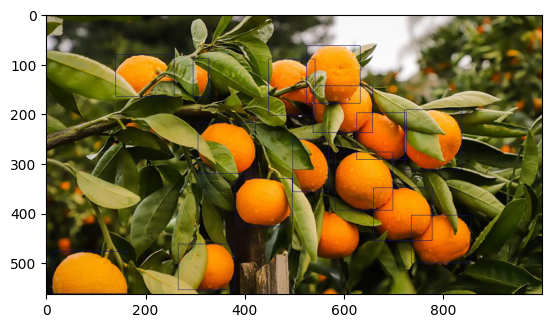

In [17]:
image_cv = cv2.imread('mandarinas.jpg')

# Draw the bounding boxes over fruit contours
for _, r in df_labels.iterrows():

        x_min = round(r['x_min'])
        x_max = round(r['x_max'])
        y_min = round(r['y_min'])
        y_max = round(r['y_max'])
        image_cv = cv2.rectangle(image_cv,(int(x_min),int(y_min)), \
                                 (int(x_max),int(y_max)),(100,20,20), \
                                 thickness=1)

show_img(image_cv)


**Algorithm**

1. We cut the bounding box to the FASTER-RCNN output, where we know we have an tangerine label.
2. Transform the image from the RGB/BGR space to the HSV space.
3. Let´s apply the *cv2.threshold()* algorithm with *THRESH_BINARY* technique. With *cv2.threshold(source, thresholdValue, maxVal, thresholdingTechnique)* we are able to get a mask of ones and zeros:

$$dst\left(x,y\right) = \begin{cases} maxval & & if \hspace{2mm} src\left(x,y\right)>thresh,  \\ 0 & & otherwise. \end{cases}$$

4. Change the hue from the orange range to yellow range (or the color we want to set) where the mask.

5. Transform the image to RGB/BGR space again.

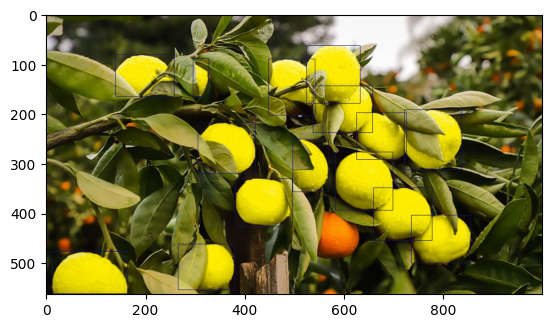

In [18]:
for _, r in df_labels.iterrows():

        x_min = round(r['x_min'])
        x_max = round(r['x_max'])
        y_min = round(r['y_min'])
        y_max = round(r['y_max'])

        # 1. Cut the image to the bounding box
        bbox = image_cv[y_min:y_max,x_min:x_max]

        # 2. Transform from BGR to HSV
        hsv_bbox = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)

        # 3. Threshold algorithm
        ret, mask = cv2.threshold(bbox[:, :,2], 65, 255, cv2.THRESH_BINARY)
        imask = mask > 0

        # 4. Orange to yellow where the mask
        indices = np.where(imask==1)
        bbox[indices[0], indices[1], :] = [0, 234, 255]

        hsv_bbox_new = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)
        hsv_bbox[indices[0], indices[1], 0] = np.array(hsv_bbox_new[indices[0], indices[1], 0])

        # 5. Transform from HSV to RGB/BGR again
        bbox_new = cv2.cvtColor(hsv_bbox, cv2.COLOR_HSV2BGR)
        image_cv[y_min:y_max,x_min:x_max] = bbox_new

show_img(image_cv)

## Turning on traffic lights

We have seen a very practical use case related to precision agriculture. However, we can apply it to any case in image detection. For example, we can use it to manipulate the image color of traffic lights.

In [19]:
# Download images and labels
!wget https://raw.githubusercontent.com/josefernandezest98/training/main/Fruit_Thresholding/semaforo.jpg
!wget https://raw.githubusercontent.com/josefernandezest98/training/main/Fruit_Thresholding/labels_semaforo_kitti.txt

--2023-09-15 10:27:47--  https://raw.githubusercontent.com/josefernandezest98/training/main/Fruit_Thresholding/semaforo.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67931 (66K) [image/jpeg]
Saving to: ‘semaforo.jpg.2’

semaforo.jpg.2      100%[===================>]  66.34K  --.-KB/s    in 0.01s   

2023-09-15 10:27:47 (5.31 MB/s) - ‘semaforo.jpg.2’ saved [67931/67931]

--2023-09-15 10:27:47--  https://raw.githubusercontent.com/josefernandezest98/training/main/Fruit_Thresholding/labels_semaforo_kitti.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

In [20]:
fichero = 'labels_semaforo_kitti.txt'
df_labels = pd.DataFrame()

# Save the bounding boxes on a DataFrame
with open(fichero) as X:

        for line in X:

            linea = line.split(" ")
            x_min = float(linea[4])
            y_min = float(linea[5])
            x_max = float(linea[6])
            y_max = float(linea[7])
            prob = float(linea[-1][:-1])
            inner = pd.DataFrame({'x_min': [x_min], 'y_min': [y_min], 'x_max': [x_max],
                                  'y_max': [y_max]})

            df_labels = pd.concat([df_labels,inner],ignore_index=True)

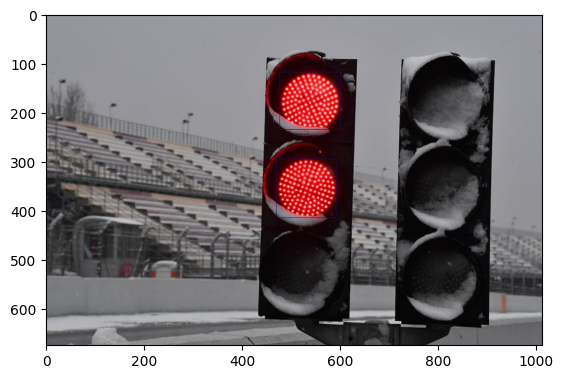

In [21]:
image_cv = cv2.imread('semaforo.jpg')

# Draw the bounding boxes over fruit contours
for _, r in df_labels.iterrows():

        x_min = round(r['x_min'])
        x_max = round(r['x_max'])
        y_min = round(r['y_min'])
        y_max = round(r['y_max'])
        image_cv = cv2.rectangle(image_cv,(int(x_min),int(y_min)), \
                                 (int(x_max),int(y_max)),(100,20,20), \
                                 thickness=1)

show_img(image_cv)


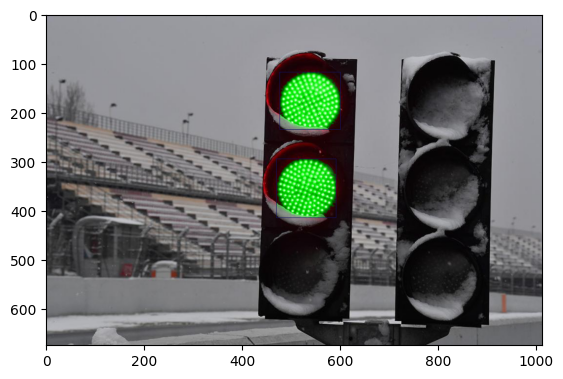

In [22]:
for _, r in df_labels.iterrows():

        x_min = round(r['x_min'])
        x_max = round(r['x_max'])
        y_min = round(r['y_min'])
        y_max = round(r['y_max'])

        # 1. Cut the image to the bounding box
        bbox = image_cv[y_min:y_max,x_min:x_max]
        hsv_bbox = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)

        # 2. Transform from BGR to HSV
        ret, mask = cv2.threshold(bbox[:, :,2], 65, 255, cv2.THRESH_BINARY)
        imask = mask > 0

        # 3. Threshold algorithm
        indices = np.where(imask==1)
        bbox[indices[0], indices[1], :] = [0, 204, 0]

        # 4. Red to green where the mask
        hsv_bbox_new = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)
        hsv_bbox[indices[0], indices[1], 0] = np.array(hsv_bbox_new[indices[0], indices[1], 0])

        # 5. Transform from HSV to RGB/BGR again
        bbox_new = cv2.cvtColor(hsv_bbox, cv2.COLOR_HSV2BGR)
        image_cv[y_min:y_max,x_min:x_max] = bbox_new

show_img(image_cv)



---



# Difficulties and next steps

There are several issues that are not solved yet, and may cause difficulties when performing the algorithm. The most important I had to deal with is:

*  Lightning and shadows can burn the image and lose information, this way the hue value is not totally identified. It can cause partial masks and the color does not fill the contour.



---



# References

<a href="#ref1"></a>
 [1] Tang, Y., Qiu, J., Zhang, Y. et al. Optimization strategies of fruit detection to overcome the challenge of unstructured background in field orchard environment: a review. Precision Agric 24, 1183–1219 (2023). [https://doi.org/10.1007/s11119-023-10009-9](https://doi.org/10.1007/s11119-023-10009-9)



---


